In [1]:
import pandas as pd
import io
import requests
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

pd.options.display.max_columns = 50

In [2]:
# get sample data
url_data = "http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/diabetes.csv"
r = requests.get(url_data).content
df = pd.read_csv(io.StringIO(r.decode('utf-8')))
df.head(10)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0
5,1008,248.0,94,69.0,3.6,4.81,Buckingham,34,male,71.0,190.0,large,132.0,86.0,NaN,NaN,36.0,42.0,195.0
6,1011,195.0,92,41.0,4.8,4.84,Buckingham,30,male,69.0,191.0,medium,161.0,112.0,161.0,112.0,46.0,49.0,720.0
7,1015,227.0,75,44.0,5.2,3.94,Buckingham,37,male,59.0,170.0,medium,NaN,NaN,NaN,NaN,34.0,39.0,1020.0
8,1016,177.0,87,49.0,3.6,4.84,Buckingham,45,male,69.0,166.0,large,160.0,80.0,128.0,86.0,34.0,40.0,300.0
9,1022,263.0,89,40.0,6.6,5.78,Buckingham,55,female,63.0,202.0,small,108.0,72.0,NaN,NaN,45.0,50.0,240.0


In [9]:
# calculate bmi
df['bmi'] = 703 * df['weight'] / df['height']**2 # Formula: 703 x weight (lbs) / [height (in)]2

# drop due to presence of nan's
df = df.drop(['bp.2s','bp.2d'], 1)

Let's examine the data for relationships...

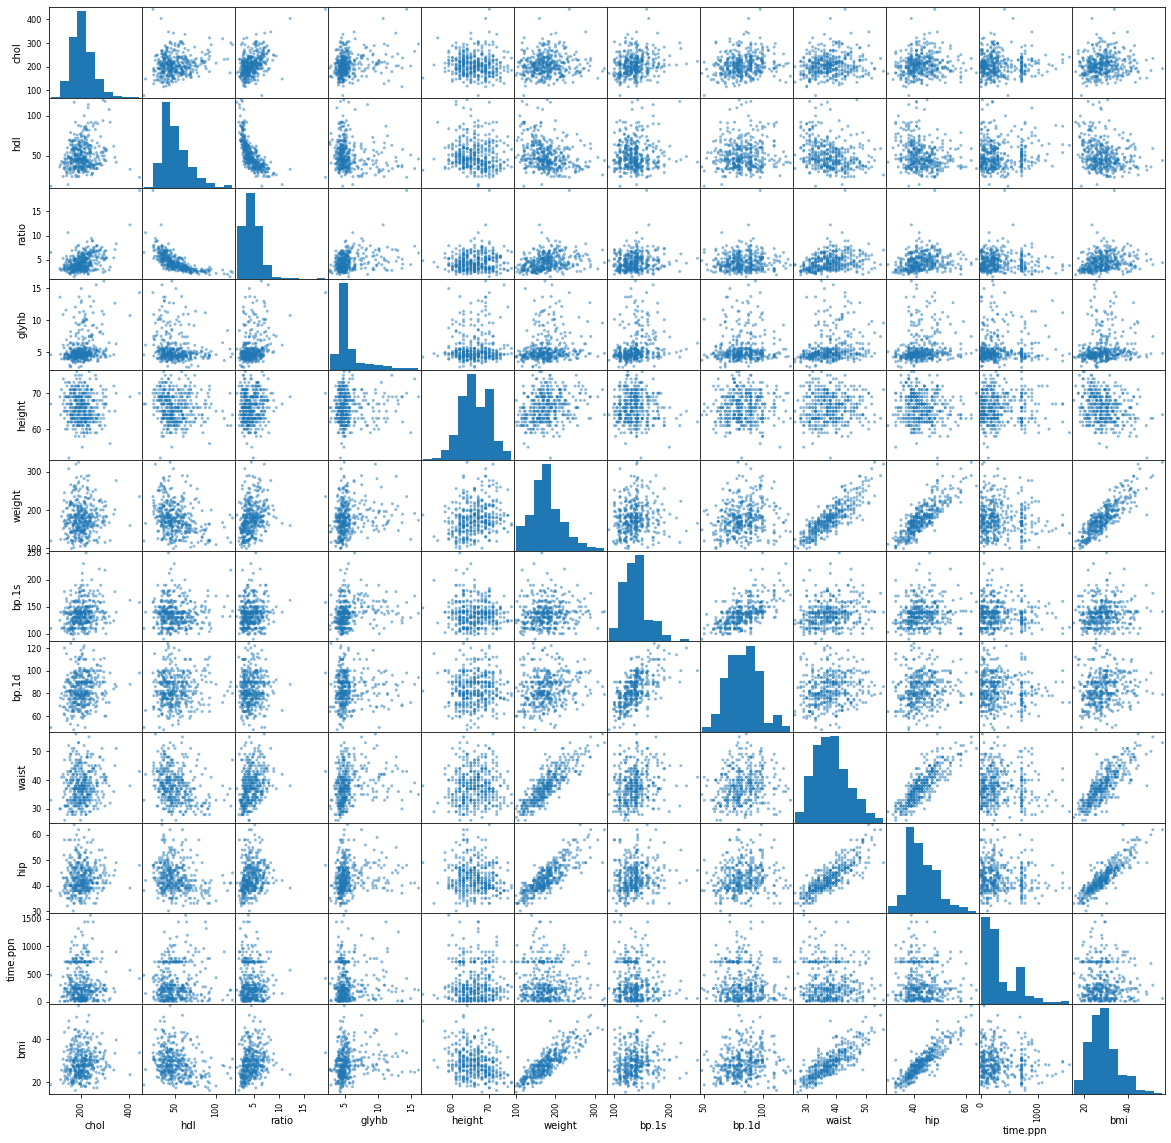

In [10]:
feature_vars = df.dtypes[df.dtypes != np.object].index
continuous_vars = df.dtypes[df.dtypes == np.float64].index

from pandas.plotting import scatter_matrix
scatter_matrix(df[continuous_vars], figsize=(20,20));

## Setup variables...

In [85]:
x_var = 'ratio'
y_var = 'bmi'

dft = df[[x_var, y_var]].dropna()

x = dft[x_var].values

y = dft[y_var].values

## use scipy's `linregress` function first,

In [86]:
from scipy.stats import linregress

0.8540954818175489 24.959044925352455 0.22553949590778427 5.828325295009374e-06 0.18586559287824966


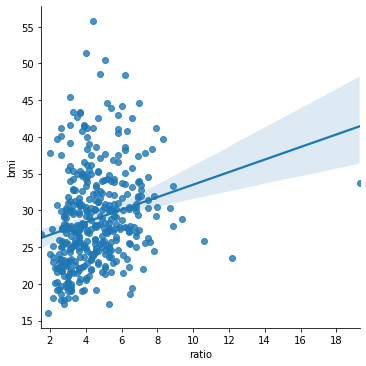

In [87]:
slope, intercept, r_value, p_value, std_err = linregress(x, y,)

sns.lmplot(x=x_var, y=y_var, data=dft, );

print(slope, intercept, r_value, p_value, std_err)

linregress has no option to fix the y-intercept at 0...

Let's try statsmodels API

## Statsmodels - sm

In [88]:
import statsmodels.api as sm

In [89]:
# Fit and summarize OLS model, including fitting of y-intercept
x_w_const = sm.add_constant(x, prepend=False)
mod = sm.OLS(y, x_w_const)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     21.12
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           5.83e-06
Time:                        15:21:56   Log-Likelihood:                -1297.1
No. Observations:                 396   AIC:                             2598.
Df Residuals:                     394   BIC:                             2606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8541      0.186      4.595      0.0

In [90]:
# Fit and summarize OLS model, don't fit y-intercept (fix at 0)
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                              2457.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):                   1.17e-171
Time:                        15:21:57   Log-Likelihood:                         -1511.5
No. Observations:                 396   AIC:                                      3025.
Df Residuals:                     395   BIC:                                      3029.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

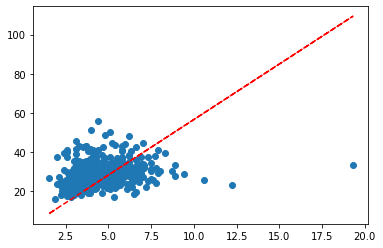

In [91]:
plt.scatter(x, y);
y_pred = [val * res.params[0] for val in x]
plt.plot(x, y_pred, ls='--', color='r');